[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/041_attention/attention.ipynb)

# Mecanismos de Atención

En el [post](https://sensioai.com/blog/040_encoder_decoder) anterior aprendimos a implementar una arquitectura de red neuronal conocida como `seq2seq`, que utiliza dos redes neuronales (el `encoder` y el `decoder`) para poder trabajar con secuencias de longitud arbitraria tanto a sus entradas como en las salidas. Este modelo nos permite llevar a cabo tareas tales como la traducción de texto entre dos idiomas, resumir un texto, responder preguntas, etc.

![](https://pytorch.org/tutorials/_images/seq2seq.png)

Si bien este modelo nos dio buenos resultados, podemos mejorarlo. Si prestamos atención a la arquitectura que desarrollamos, el `decoder` (encargado de generar la secuencia de salida) es inicializado con el último estado oculto del `encoder`, el cual tiene la responsabilidad de codificar el significado de toda la frase original. Esto puede ser complicado, sobre todo al trabajar con secuencias muy largas, y para solventar este problema podemos utilizar un mecanismo de `atención` que no solo reciba el último estado oculto si no también tenga acceso a todas las salidas del `encoder` de manera que el `decoder` sea capaz de "focalizar su atención" en aquellas partes más importantes. Por ejemplo, para traducir la primera palabra es lógico pensar que lo más importante será la primera palabra y sus adyacentes en la frase original, pero usar el último estado oculto del `encoder` puede no ser suficiente para mantener estas relaciones a largo plazo. Permitir al `decoder` acceder a esta información puede resultar en mejores prestaciones.

> 💡 En la práctica, los mecanismos de atención dan muy buenos resultados en tareas que envuelvan datos secuenciales (como aplicaciones de lenguaje). De hecho, los mejores modelos a día de hoy para tareas de `NLP` no están basados en redes recurrentes sino en arquitecturas que únicamente implementan mecanismos de atención en varias capas. Estas redes neuronales son conocidas como `Transformers`.

## El *dataset*

Vamos a resolver exactamente el mismo caso que en el post anterior, así que todo lo que hace referencia al procesado de datos lo dejaremos igual.

In [1]:
import unicodedata
import re

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def read_file(file, reverse=False):
    # Read the file and split into lines
    lines = open(file, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    return pairs

In [2]:
pairs = read_file('deu.txt')

In [3]:
import random

random.choice(pairs)

['is this for me ?', 'ist das fur mich ?']

In [4]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1, "PAD": 2}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "PAD"}
        self.n_words = 3  # Count SOS, EOS and PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def indexesFromSentence(self, sentence):
        return [self.word2index[word] for word in sentence.split(' ')]

    def sentenceFromIndex(self, index):
        return [self.index2word[ix] for ix in index]

Para poder aplicar la capa de `attention` necesitamos que nuestras frases tengan una longitud máxima definida.

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPairs(pairs, filters, lang=0):
    return [p for p in pairs if p[lang].startswith(filters)]

def trimPairs(pairs):
    return [p for p in pairs if len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH]

In [7]:
def prepareData(file, filters=None, reverse=False):

    pairs = read_file(file, reverse)
    print(f"Tenemos {len(pairs)} pares de frases")

    if filters is not None:
        pairs = filterPairs(pairs, filters, int(reverse))
        print(f"Filtramos a {len(pairs)} pares de frases")

    pairs = trimPairs(pairs)
    print(f"Tenemos {len(pairs)} pares de frases con longitud menor de {MAX_LENGTH}")

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang('eng')
        output_lang = Lang('deu')
    else:
        input_lang = Lang('deu')
        output_lang = Lang('eng')

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

        # add <eos> token
        pair[0] += " EOS"
        pair[1] += " EOS"

    print("Longitud vocabularios:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('deu.txt')

# descomentar para usar el dataset filtrado
#input_lang, output_lang, pairs = prepareData('spa.txt', filters=eng_prefixes)

random.choice(pairs)

Tenemos 145759 pares de frases
Tenemos 144112 pares de frases con longitud menor de 10
Longitud vocabularios:
deu 10552
eng 19777


['cats are natural born hunters . EOS', 'katzen sind geborene jager . EOS']

In [8]:
output_lang.indexesFromSentence('ich bin so durstig .')

[36, 92, 604, 1491, 4]

In [9]:
output_lang.sentenceFromIndex([3, 1028, 647, 5])

['geh', 'stark', 'blind', 'hallo']

En el `Dataset` nos aseguraremos de añadir el *padding* necesario para que todas las frases tengan la misma longitud, lo cual no hace necesario utilizar la función `collate` que implementamos en el post anterior.

In [10]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, input_lang, output_lang, pairs, max_length):
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.pairs = pairs
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, ix):
        inputs = torch.tensor(self.input_lang.indexesFromSentence(self.pairs[ix][0]), device=device, dtype=torch.long)
        outputs = torch.tensor(self.output_lang.indexesFromSentence(self.pairs[ix][1]), device=device, dtype=torch.long)
        # metemos padding a todas las frases hast a la longitud máxima
        return torch.nn.functional.pad(inputs, (0, self.max_length - len(inputs)), 'constant', self.input_lang.word2index['PAD']), \
            torch.nn.functional.pad(outputs, (0, self.max_length - len(outputs)), 'constant', self.output_lang.word2index['PAD'])

# separamos datos en train-test
train_size = len(pairs) * 80 // 100
train = pairs[:train_size]
test = pairs[train_size:]

dataset = {
    'train': Dataset(input_lang, output_lang, train, max_length=MAX_LENGTH),
    'test': Dataset(input_lang, output_lang, test, max_length=MAX_LENGTH)
}

len(dataset['train']), len(dataset['test'])

(115289, 28823)

In [11]:
input_sentence, output_sentence = dataset['train'][1]

input_sentence, output_sentence

(tensor([5, 4, 1, 2, 2, 2, 2, 2, 2, 2], device='cuda:0'),
 tensor([5, 6, 1, 2, 2, 2, 2, 2, 2, 2], device='cuda:0'))

In [12]:
input_lang.sentenceFromIndex(input_sentence.tolist()), output_lang.sentenceFromIndex(output_sentence.tolist())

(['hi', '.', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'],
 ['hallo', '!', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'])

In [13]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False),
}

inputs, outputs = next(iter(dataloader['train']))
inputs.shape, outputs.shape

(torch.Size([64, 10]), torch.Size([64, 10]))

## El modelo

En lo que se refiere al `encoder`, seguimos usando exactamente la misma arquitectura. La única diferencia es que, además del último estado oculto, necesitaremos todas sus salidas para que el `decoder` pueda usarlas.

In [14]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size=100, hidden_size=100, n_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.gru = torch.nn.GRU(embedding_size, hidden_size, num_layers=n_layers, batch_first=True)

    def forward(self, input_sentences):
        embedded = self.embedding(input_sentences)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

In [15]:
encoder = Encoder(input_size=input_lang.n_words)
encoder_outputs, encoder_hidden = encoder(torch.randint(0, input_lang.n_words, (64, 10)))

# [batch size, seq len, hidden size]
encoder_outputs.shape

torch.Size([64, 10, 100])

In [16]:
# [num layers, batch size, hidden size]
encoder_hidden.shape

torch.Size([2, 64, 100])

### El *decoder* con *attention*

Vamos a ver un ejemplo de implementación de una capa de atención para nuestro `decoder`. En primer lugar tendremos una capa lineal que recibirá como entradas los `embeddings` y el estado oculto anterior (concatenados). Esta capa lineal nos dará a la salida tantos valores como elementos tengamos en nuestras secuencias de entrada (recuerda que las hemos forzado a tener una longitud determinada). Después, aplicaremos una función `softmax` sobre estos valores obteniendo así una distribución de probabilidad que, seguidamente, multiplicaremos por los *outputs* del encoder (que también tienen la misma longitud). En esta función de probabilidad, cada elemento tiene un valor entre 0 y 1. Así pues, esta operación dará más importancia a aquellos *outputs* del `encoder` más importantes mientras que al resto les asignará unos valores cercanos a 0. A continuación, concatenaremos estos valores con los `embeddings`, de nuevo, y se lo daremos a una nueva capa lineal que combinará estos `embeddings` con los *outputs* del `encoder` re-escalados para obtener así los *inputs* finales de la capa recurrente.

En resumen, usaremos las entradas y estado oculto del `decoder` para encontrar unos pesos que re-escalarán las salidas del `encoder`, los cuales combinaremos de nuevo con las entradas del `decoder` para obtener las representaciones finales de nuestras frases que alimentan la capa recurrente.

![](https://i.imgur.com/1152PYf.png)

In [17]:
class AttnDecoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size=100, hidden_size=100, n_layers=2, max_length=MAX_LENGTH):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.gru = torch.nn.GRU(embedding_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.out = torch.nn.Linear(hidden_size, input_size)

        # attention
        self.attn = torch.nn.Linear(hidden_size + embedding_size, max_length)
        self.attn_combine = torch.nn.Linear(hidden_size * 2, hidden_size)


    def forward(self, input_words, hidden, encoder_outputs):
        # sacamos los embeddings
        embedded = self.embedding(input_words)
        # calculamos los pesos de la capa de atención
        attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded.squeeze(1), hidden[0]), dim=1)))
        # re-escalamos los outputs del encoder con estos pesos
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        output = torch.cat((embedded.squeeze(1), attn_applied.squeeze(1)), 1)
        # aplicamos la capa de atención
        output = self.attn_combine(output)
        output = torch.nn.functional.relu(output)
        # a partir de aquí, como siempre. La diferencia es que la entrada a la RNN
        # no es directmanete el embedding sino una combinación del embedding
        # y las salidas del encoder re-escaladas
        output, hidden = self.gru(output.unsqueeze(1), hidden)
        output = self.out(output.squeeze(1))
        return output, hidden, attn_weights

In [18]:
decoder = AttnDecoder(input_size=output_lang.n_words)
decoder_output, decoder_hidden, attn_weights = decoder(torch.randint(0, output_lang.n_words, (64, 1)), encoder_hidden, encoder_outputs)

# [batch size, vocab size]
decoder_output.shape

<ipython-input-17-51f795b71400>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded.squeeze(1), hidden[0]), dim=1)))


torch.Size([64, 19777])

In [19]:
# [num layers, batch size, hidden size]
decoder_hidden.shape

torch.Size([2, 64, 100])

In [20]:
# [num layers, batch size, hidden size]
decoder_hidden.shape

torch.Size([2, 64, 100])

In [21]:
# [batch size, max_length]
attn_weights.shape

torch.Size([64, 10])

## Entrenamiento

Vamos a implementar el bucle de entrenamiento. En primer lugar, al tener ahora dos redes neuronales, necesitaremos dos optimizadores (uno para el `encoder` y otro para el `decoder`). Al `encoder` le pasaremos la frase en el idioma original, y obtendremos el estado oculto final. Este estado oculto lo usaremos para inicializar el `decoder` que, junto al token `<sos>`, generará la primera palabra de la frase traducida. Repetiremos el proceso, utilizando como entrada la anterior salida del decoder, hasta obtener el token `<eos>`.

In [22]:
from tqdm import tqdm
import numpy as np

def fit(encoder, decoder, dataloader, epochs=10):
    encoder.to(device)
    decoder.to(device)
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        encoder.train()
        decoder.train()
        train_loss = []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            input_sentences, output_sentences = batch
            bs = input_sentences.shape[0]
            loss = 0
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            # obtenemos el último estado oculto del encoder
            encoder_outputs, hidden = encoder(input_sentences)
            # calculamos las salidas del decoder de manera recurrente
            decoder_input = torch.tensor([[output_lang.word2index['SOS']] for b in range(bs)], device=device)
            for i in range(output_sentences.shape[1]):
                output, hidden, attn_weights = decoder(decoder_input, hidden, encoder_outputs)
                loss += criterion(output, output_sentences[:, i].view(bs))
                # el siguiente input será la palabra predicha
                decoder_input = torch.argmax(output, axis=1).view(bs, 1)
            # optimización
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f}")

        val_loss = []
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            bar = tqdm(dataloader['test'])
            for batch in bar:
                input_sentences, output_sentences = batch
                bs = input_sentences.shape[0]
                loss = 0
                # obtenemos el último estado oculto del encoder
                encoder_outputs, hidden = encoder(input_sentences)
                # calculamos las salidas del decoder de manera recurrente
                decoder_input = torch.tensor([[output_lang.word2index['SOS']] for b in range(bs)], device=device)
                for i in range(output_sentences.shape[1]):
                    output, hidden, attn_weights = decoder(decoder_input, hidden, encoder_outputs)
                    loss += criterion(output, output_sentences[:, i].view(bs))
                    # el siguiente input será la palabra predicha
                    decoder_input = torch.argmax(output, axis=1).view(bs, 1)
                val_loss.append(loss.item())
                bar.set_description(f"Epoch {epoch}/{epochs} val_loss {np.mean(val_loss):.5f}")

In [23]:
fit(encoder, decoder, dataloader, epochs=30)

  0%|          | 0/1802 [00:00<?, ?it/s]<ipython-input-17-51f795b71400>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded.squeeze(1), hidden[0]), dim=1)))
Epoch 30/30 val_loss 29.44561: 100%|██████████| 113/113 [00:05<00:00, 20.12it/s]


## Generando traducciones

Una vez tenemos nuestro modelo entrenado, podemos utilizarlo para traducir frases del ingles a aleman de la siguiente manera.

In [24]:
input_sentence, output_sentence = dataset['train'][100]
input_lang.sentenceFromIndex(input_sentence.tolist()), output_lang.sentenceFromIndex(output_sentence.tolist())

(['no', 'way', '!', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'],
 ['das', 'kommt', 'nicht', 'in', 'frage', '!', 'EOS', 'PAD', 'PAD', 'PAD'])

In [64]:
def predict(input_sentence):
    # obtenemos el último estado oculto del encoder
    encoder_outputs, hidden = encoder(input_sentence.unsqueeze(0))
    # calculamos las salidas del decoder de manera recurrente
    decoder_input = torch.tensor([[output_lang.word2index['SOS']]], device=device)
    # iteramos hasta que el decoder nos de el token <eos>
    outputs = []
    decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)
    i = 0
    while True:
        output, hidden, attn_weights = decoder(decoder_input, hidden, encoder_outputs)

        if i < MAX_LENGTH:
            decoder_attentions[i] = attn_weights.data
        else:
            break
        i += 1
        decoder_input = torch.argmax(output, axis=1).view(1, 1)
        outputs.append(decoder_input.cpu().item())
        if decoder_input.item() == output_lang.word2index['EOS']:
            break
    return output_lang.sentenceFromIndex(outputs), decoder_attentions

In [65]:
output_words, attn = predict(input_sentence)
output_words

<ipython-input-17-51f795b71400>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded.squeeze(1), hidden[0]), dim=1)))


['kein', 'ist', '!', '!', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'EOS']

## Visualización de atención

Una de las ventajas que nos da la capa de atención es que nos permite visualizar en qué partes de los inputs se fija el modelo para generar cada una de las palabras en el output, dando un grado de explicabilidad a nuestro modelo (una propiedad siempre deseada en nuestro modelos de `Machine Learning`).

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def showAttention(input_sentence, output_words, attentions):
    lim1, lim2 = input_sentence.index('EOS')+1, output_words.index('EOS')+1
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions[:lim2, :lim1].numpy(), cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    ax.set_xticklabels([' '] + input_sentence[:lim1], rotation=90)
    ax.set_yticklabels([' '] + output_words)
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

<ipython-input-37-c3618fc79f44>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([' '] + input_sentence[:lim1], rotation=90)
<ipython-input-37-c3618fc79f44>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([' '] + output_words)


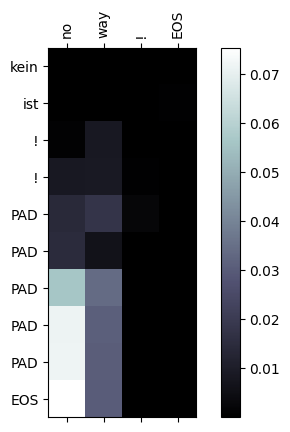

In [66]:
showAttention(input_lang.sentenceFromIndex(input_sentence.tolist()), output_words, attn)

## Resumen

En este post hemos visto como introducir mecanismos de atención en nuestra arquitectura `encoder-decoder`, los cuales permiten a nuestra red neuronal focalizarse en partes concretas de los *inputs* a la hora de generar los *outputs*. Esta nueva capa no solo puede mejorar nuestros modelos sino que además también es interpretable, dándonos una idea del razonamiento detrás de las predicciones de nuestro modelo. Las redes neuronales con mejores prestaciones a día de hoy en tareas de `NLP`, los `transformers`, están basados enteramente en este tipo de capas de atención.